In [1]:
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Next-Generation Astronomical Transient Classification via Large Language Models

<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/turanbulmus/spacehack/blob/main/01%20-%20Prompt%20Engineering.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo"><br> Open in Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2Fturanbulmus%2Fspacehack%2Fmain%2F01%20-%20Prompt%20Engineering.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo"><br> Open in Colab Enterprise
    </a>
  </td>    
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/turanbulmus/spacekhack/main/01%20-%20Prompt%20Engineering.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo"><br> Open in Workbench
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/turanbulmus/spacehack/blob/main/01%20-%20Prompt%20Engineering.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo"><br> View on GitHub
    </a>
  </td>
</table>

| Author(s) | turanbulmus
https://github.com/turanbulmus |

## Overview

This notebook showcases the potential of multimodal models like Gemini 1.5 Pro for tackling zero-shot object classification problems. We'll explore how this advanced model can analyze telescope images, compare them against reference and difference images, and classify them as "real" or "bogus" solely based on visual information and human-provided instructions. By the end of this notebook, you'll gain insights into:

* How Gemini 1.5 Pro can perform zero-shot classification tasks without explicit training.
* The power of multimodal models to understand and reason about visual content.
* Building effective prompts for complex image analysis tasks.

This notebook demonstrates the following steps:

1. **Import Libraries and Build Functions:** We start by importing the necessary libraries for image loading, processing, and evaluation. We also define functions to facilitate the analysis and visualization of results.
2. **Build System Instructions for the Prompt:** A well-crafted prompt is crucial for guiding Gemini 1.5 Pro towards the desired output. We carefully define instructions outlining the task, the type of images, and the desired classification outcome.
3. **Load the Dataset:** We load a collection of telescope images, including reference, difference, and new images, to be used for the classification task.
4. **Run Gemini 1.5 Pro with the Prompt:** We execute the prompt with Gemini 1.5 Pro, iterating over 100 samples from the dataset to get classifications for each image.
5. **Evaluate Model Performance:** We evaluate the model's performance using metrics like a confusion matrix, precision, recall, and accuracy. These metrics provide insights into the model's ability to correctly classify "real" and "bogus" images. Finally, we visualize the results for better understanding.

## Getting Started

### Install Vertex AI SDK and other required packages

In [2]:
! pip install -r requirements.txt --quiet

### Restart runtime

To use the newly installed packages in this Jupyter runtime, you must restart the runtime. You can do this by running the cell below, which restarts the current kernel.

The restart might take a minute or longer. After it's restarted, continue to the next step.

In [3]:
# import IPython

# app = IPython.Application.instance()
# app.kernel.do_shutdown(True)

<div class="alert alert-block alert-warning">
<b>⚠️ The kernel is going to restart. Please wait until it is finished before continuing to the next step. ⚠️</b>
</div>

### Authenticate your notebook environment

If you're using Colab, run the code in the next cell. Follow the popups and authenticate with an account that has access to your Google Cloud [project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#identifying_projects).

If you're running this notebook somewhere besides Colab, make sure your environment has the right Google Cloud access. If that's a new concept to you, consider looking into [Application Default Credentials for your local environment](https://cloud.google.com/docs/authentication/provide-credentials-adc#local-dev) and [initializing the Google Cloud CLI](https://cloud.google.com/docs/authentication/gcloud). In many cases, running `gcloud auth application-default login` in a shell on the machine running the notebook kernel is sufficient.

More authentication options are discussed [here](https://cloud.google.com/docs/authentication).

In [4]:
import sys

if "google.colab" in sys.modules:
    from google.colab import auth

    auth.authenticate_user()
    print('Authenticated')

### Set Google Cloud environment variables information and initialize Clients

Learn more about [setting up a project and a development environment](https://cloud.google.com/vertex-ai/docs/start/cloud-environment).
To get started using Vertex AI, you must have an existing Google Cloud project and the following:
* [Enable the Vertex AI API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com). 
* [Enable the Big Query API](https://console.cloud.google.com/flows/enableapi?apiid=bigquery.googleapis.com).

In [5]:
PROJECT_ID = "turan-genai-bb"  # @param {type:"string"}
LOCATION = "us-central1"  # @param {type:"string"}
EXPERIMENT_NAME = "supernovadetection" # @param {type:"string"}
# Make sure that dataset is created in Big Query
DATASET_ID = "spacehack" # @param {type:"string"}
import vertexai
from google.cloud import bigquery


vertexai.init(project=PROJECT_ID, location=LOCATION, experiment=EXPERIMENT_NAME)
bq_client = bigquery.Client(project=PROJECT_ID)

## Import libraries and define helper functions

In [6]:
import gdown 
import base64
import json
import random
import time, datetime
from pathlib import Path

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from vertexai.generative_models import GenerativeModel, Part, FinishReason, Image
from google.cloud import bigquery
import google.cloud.aiplatform as aiplatform

from helper_functions import build_run_batch, if_tbl_exists, create_ex, save_picture, save_prompt, build_experiment_vars

In [7]:
# Build the system instructions
PERSONA = """<PERSONA>
You are an experienced astrophysicist, and your task is to classify astronomical transients into Real or Bogus based on a given set of 3 images. You have seen thousands of astronomical images during your lifetime and you are very good at making this classification by looking at the images and following the instructions. 
</PERSONA>"""

INSTRUCTIONS = """\n<INSTRUCTIONS>
**1. Purpose**
This guide is designed to help vet astronomical data for the Real/Bogus classification. The goal is for you to learn how to distinguish between real and bogus sources. 

**2. Information Provided**
You will be shown three astronomical image cutouts:
a) **New Image:** The newest fully reduced science image centred at the location of the suspected transient source. 
b) **Reference Image:** A reference image from the same telescope of the same part of the sky to be used for comparison. It shows if the source was already there in the past or not.
c) **Difference Image:** The residual image after the new and reference images are subtracted (sky-subtracted and scaled/convolved to match PSFs). Real sources should appear in this cutout as circular objects with positive (or negative) flux. Imperfect astrometric regridding can cause ‘ying-yang’ patterns of positive and negative flux at the same time. If the source of interest at the centre of the cutout presents this feature it is to be considered as Bogus.

**3. Real and Bogus Sources**
To classify the sources, you need to understand what constitutes a real or bogus source: 

**Real Source** 
A real source is any astrophysical origin that is variable in time. Characteristics of a real source include: 
a) **Shape:** The source at the centre appears as a point source with a circular shape and a visual extent of ~5-10 pixels, varying with focus conditions. 
b) **Brightness:** The source at the centre is positive in either the new or reference image. 
c) **Variability:** The source at the centre can fade or brighten between the new and reference image, appearing as positive or negative in the difference image. 
d) **Presence:** The source may (dis)appear between the new and reference image. It can happen that there is no source in one image and a clear point-source in the other. It can also occur that a source appears on top of an underlying galaxy (e.g. SN). 

**Bogus Source** 
A bogus source is any source not of astrophysical origin, such as detector artefacts, cosmic rays, reflections, data processing errors, cross-talk, or diffraction spikes. 
Characteristics of a bogus source include: 
a) **Shape:** The source at the centre is not circular (e.g., elongated) with a size <5 pixels or >10 pixels. A single bright pixel is not a point-source (likely a cosmic-ray). This also includes irregular shapes like streaks or lines caused by cross-talk or diffraction spikes. 
b) **Brightness:** The source at the centre is negative (dark) in either the new or reference image. The source at the centre of the cutouts can never be negative in the new or reference image. 
c) **Artifacts:** The source at the centre is simply a detector artifacts such as reflections,  cross-talk, and dead pixels. Diffraction spikes from nearby bright stars or other optical effects can also create potential Bogus sources. 
d) **Misalignment** If the source in the New and Reference image are misaligned it will show a Yin Yang pattern in the difference image, this is a Bogus.
 
**4. Additional Guidance** 
a) **Contextual Information:** The classification in Real or Bogus is for the source at the centre of the cutours, but keep in mind that sources nearby can help is diagnose problems in the difference image.  
b) **Examples:** Refer to provided visual examples of real and bogus sources to aid in identification. 
c) **Judgment Criteria:** For ambiguous cases or borderline scenarios, consider the overall context and consistency with known characteristics of real and bogus sources. 

**5. Misalignment of real image and reference image**
If New and Reference image present a realistic source but the difference image have a Yin Yang pattern, this is a Bogus. It is simply due to a misalignment of the New and Reference image.
</INSTRUCTIONS> """

TASK = """<TASK>
Your task is to read the INSTRUCTIONS, look at the 3 images (New, Reference and Difference images) and classify if the source at the centre is a Real or Bogus astronomical transient. Provide your thought process to explain how you reasoned to provide the response. Respond in json format. 
</TASK>\n
"""

METHOD = """<METHOD>
Do not simply provide a binary classification. Utilize your knowledge, the provided guide, and the image data to generate a comprehensive explanation for your classification.
Base your reasoning by only looking at the center of the image. The images are prepared specifically so that the questioned light source sits at the center of the image.
Employ a chain-of-thought process, clearly outlining each step of your analysis.
Analyze each image individually and in relation to each other.
For each feature you examine (shape, flux, etc.), describe your observations and how they contribute to your classification.
If you observe features from the images described in the <INSTRUCTIONS> section, clearly identify them and relate them to your reasoning.
If any of your observations contradict a potential classification, acknowledge the discrepancy and justify your final decision.
</METHOD>
"""
# Collapse the System Instructions into a single variable
stat_prompt = PERSONA + INSTRUCTIONS + METHOD + TASK 

In [8]:
# Prompt examples Build

file_path_data = 'data/new_data.npy'
file_path_labels = 'data/new_labels.npy'

# Load the .npy file containing the quadruplets of images
id = "1BYcdnknvUh7Ghe-zb5LfViyfak7YjF-Y" #id from the Google Drive
#gdown.download(id=id, output = file_path_data)
# Load the .npy file containing the labels
id =  "1--_6XLpz-NWddPZ_HegWvaPpzBDlQPwy" #id from the Google Drive
#gdown.download(id=id, output = file_path_labels)


quadruplets = np.load(file_path_data)

# Load the labels and create index
labels = np.load(file_path_labels)
index = np.arange(stop=len(labels), dtype=int)

# Combine the index and label arrays using 'zip' and convert to a NumPy array
labels_with_index = np.array(list(zip(index, labels)), dtype='object')
labels_df = pd.DataFrame(labels_with_index, columns=["index_no", 'label'])
labels_df['label'] = labels_df['label'].apply(lambda x: 'Real' if x > 0.5 else 'Bogus')


# Upload Labels to Big Query Check if the table exists
labels_id = "labels_df"
# Construct the table reference
labels_ref = bq_client.dataset(DATASET_ID).table(labels_id)
# Creates the if it doesnt exists.
create_table_flag = if_tbl_exists(bq_client, labels_ref)
# Upload labels_df to Big Query
if create_table_flag != True:
    bq_client.load_table_from_dataframe(labels_df,labels_ref)

# Sample indexes you want to access and save them as files so that sent to Gemini
sample_indexes = [0, 1, 3, 4, 8, 48, 77,  1179,  1180,  1181,  1191, 1193, 592, 685]
train_labels_id = "1-4HSiQWPjJYinhYrq-nw33eY-3SzZXqz"
train_data_id = "1--yYNr67knDfqiTHJe8bjaBjRoq2GjUP"
train_data_path = "data/pics/prompt_pics/train_data.npy"
train_label_path = "data/pics/prompt_pics/train_label.npy"
#gdown.download(id=train_data_id, output = train_data_path)
#gdown.download(id=train_labels_id, output = train_label_path)

train_data = np.load(train_data_path)
for i in sample_indexes:
    save_picture(train_data, i, True)

# For the dynamic part of the prompt generate and save the pictures in a folder
batch_index = index 
for t in batch_index:
    save_picture(quadruplets, t, False)

In [9]:
## DESCRIPTION INDEX 0:
desc1 = {
  "class": "Bogus",
  "explanation": "A diffraction spike is present in all three images. No circular source is found at the center of the New or Reference image; this is a bogus source."
}

## DESCRIPTION INDEX 1:
desc2 = {
  "class": "Bogus",
  "explanation": "The New image has a negative artefact at its center (not to be confused with the source slightly off-centre), so it is not a real source. A negative artefact in the New image can create a misleading negative source that could look like a real source that got dimmer, however remember that the source can never be negative in the New image."
}

## DESCRIPTION INDEX 3:
desc3 = {
  "class": "Bogus",
  "explanation": "In the New image the source is a streak of few really bright pixels and not circular. No source at the same location (center of the cutout)  in the Reference image. This is too sharp to be a real source and most likely a cosmic ray."
}

## DESCRIPTION INDEX 4:
desc4 = {
  "class": "Bogus",
  "explanation": "In the Reference image the source is a streak of few really bright pixels and not circular. No source at the same location (center of the cutout)  in the New image. This is too sharp to be a real source and most likely a cosmic ray that was not flagged during the Reference images creation."
}

## DESCRIPTION INDEX 8:
desc5= {
  "class": "Bogus",
  "explanation": "No source seems to be present in the New image. In the Reference image, the source appears as a negative circular object, and therefore this cannot be real. It is most likely a lump of dead pixels that have gone unflagged during the reference image creation."
}

## DESCRIPTION INDEX 48:
desc6 = {
  "class": "Bogus",
  "explanation": "There is a really faint source in the New image. The Reference image has an elongated source that is likely not a real source. A negative elongated source appears in the Difference image, confirming this is not a real source."
}

## DESCRIPTION INDEX 77:
desc7 = {
  "class": "Bogus",
  "explanation": "In both the New and Reference images, there is the same central source (and a bunch of other sources around). However, in the Difference image, there are clear Yin-Yang patterns, suggesting that the reason why the source is suspected to be a transient is only due to misalignment."
}

## DESCRIPTION INDEX 1179:
desc8 = {
  "class": "Real",
  "explanation": "The source is present at the same location in all three images. The Difference image shows a positive residual signifying that the source is likely a variable star and it has brightened."
}

## DESCRIPTION INDEX 1180:
desc9 = {
  "class": "Real",
  "explanation": "The source is present at the same location in all three images. The Difference image shows a negative residual, signifying that the source is likely a variable star that has dimmed."
}

## DESCRIPTION INDEX 1181:
desc10 = {
  "class": "Real",
  "explanation": "In the New image there is no source at the center of the cutout. The Reference image however presents a good circular source at its center. This leaves a negative, point-source-like object in the Difference image, as expected from a transient that disappeared."
}

## DESCRIPTION INDEX 1191:
desc11 = {
  "class": "Real",
  "explanation": "There is a bright circular source in the center of the New image. No source can be seen at the same central location in the Reference image. The Difference image has a positive circular source as expected from a real (explosive) transient."
}

## DESCRIPTION INDEX 1193:
desc12 = {
  "class": "Real",
  "explanation": "The source is present at the same location in all three images. The Difference image shows a positive residual signifying that the source is likely a variable star and it has brightened. The cutouts also show a cosmic ray on the left of the source, however, the central source is a good transient, and we can disregard the artefact."
}

## DESCRIPTION INDEX 592:
desc13 = {
  "class": "Bogus",
  "explanation": "A diffused source is at the centre of the New image, aligned with the 45-degree diffraction spike of a bright source at the cutout corner. The Reference image also shows a similar diffraction spike and blob. The Difference image displays a positive blob, which is a bogus source caused by the diffraction spike. Diffraction spikes can sometimes appear with blobs or irregularities instead of straight lines."
}

## DESCRIPTION INDEX 685:
desc14 = {
  "class": "Bogus",
  "explanation": "There is no source at the centre of the New image. The Reference image shows a faint positive trail cutting diagonally across the image with a circular source at its centre. This is likely an artefact caused by a faint blinking object such as an airplane or satellite. The Difference image displays both the trail and a negative blob, confirming a bogus source of non-astronomical origin."
}

descriptions = [str(desc1), str(desc2), str(desc3), str(desc4), str(desc5), str(desc6),str(desc7), str(desc8), str(desc9), str(desc10), str(desc11), str(desc12), str(desc13), str(desc14)]

### Write the examples used in a readable format to be saved as a txt file for tracebility
example_description = list(zip(["DESCRIPTION INDEX: " + str(x) for x in sample_indexes], descriptions))

In [10]:
# Report 3 Real and 3 Bogus examples for the dynamic prompt
EXAMPLES = ["<EXAMPLES>\n"]
for i in range(len(sample_indexes)):
    
    str_EX = f"""Example {i+1}:
    """
    all_list = create_ex(sample_indexes[i], True)
    all_list.insert(0, str_EX)
    all_list.append(descriptions[i])
    all
    for k in all_list:
        EXAMPLES.append(k)
EXAMPLES.append("\n</EXAMPLES>\n")

In [11]:
# Start logging the experiment

## Prepare the variables
timestamp = datetime.datetime.now()
formatted_datetime = timestamp.strftime('%Y%m%d%H%M')


## Log the experiments variables
### Create the run name with timestamp
run_name = "run" + formatted_datetime
DESCRIPTION = """This is the first experiment after running a hyper parameter optimziation on models, temperature and top p. For the selected runs, I am not testing some of these hyperparameters on the full test set. 
The hyperparameters are: 
Temperature: 0
Top P: 1
""" # @param {type:"string"}
MODEL = "gemini-1.5-pro-001" # @param [gemini-1.5-pro-001", "gemini-1.5-flash-001", "gemini-1.0-pro-002"]
TEMPERATURE = 0 # @param {type:"slider", min:0, max:2, step:0.1}
TOP_P = 1 # @param {type:"slider", min:0, max:1, step:0.05}
PROMPT_FILE = save_prompt(stat_prompt + '\n'.join([a + "\n" + b + "\n" for (a,b) in example_description]), run_name)

# Build the experimentation variables
exp_vars = build_experiment_vars(description=DESCRIPTION,prompt=PROMPT_FILE, model=MODEL, temperature=TEMPERATURE, top_p=TOP_P)
# Start the run
aiplatform.start_run(run_name)
# Log the experiment variables
aiplatform.log_params(exp_vars)

Associating projects/355771430623/locations/us-central1/metadataStores/default/contexts/supernovadetection-run202408062114 to Experiment: supernovadetection


In [13]:
# Build and then the batch run requests
pred_df = build_run_batch(bq_client, batch_index, labels_ref, PROJECT_ID, DATASET_ID, run_name, MODEL, stat_prompt, EXAMPLES, TEMPERATURE, TOP_P)

BatchPredictionJob projects/355771430623/locations/us-central1/batchPredictionJobs/8530860477939449856 current state:
JobState.JOB_STATE_QUEUED
BatchPredictionJob projects/355771430623/locations/us-central1/batchPredictionJobs/8530860477939449856 current state:
JobState.JOB_STATE_QUEUED
BatchPredictionJob projects/355771430623/locations/us-central1/batchPredictionJobs/8530860477939449856 current state:
JobState.JOB_STATE_QUEUED
BatchPredictionJob projects/355771430623/locations/us-central1/batchPredictionJobs/8530860477939449856 current state:
JobState.JOB_STATE_QUEUED
BatchPredictionJob projects/355771430623/locations/us-central1/batchPredictionJobs/8530860477939449856 current state:
JobState.JOB_STATE_QUEUED
BatchPredictionJob projects/355771430623/locations/us-central1/batchPredictionJobs/8530860477939449856 current state:
JobState.JOB_STATE_QUEUED
BatchPredictionJob projects/355771430623/locations/us-central1/batchPredictionJobs/8530860477939449856 current state:
JobState.JOB_STATE

<Figure size 640x480 with 0 Axes>

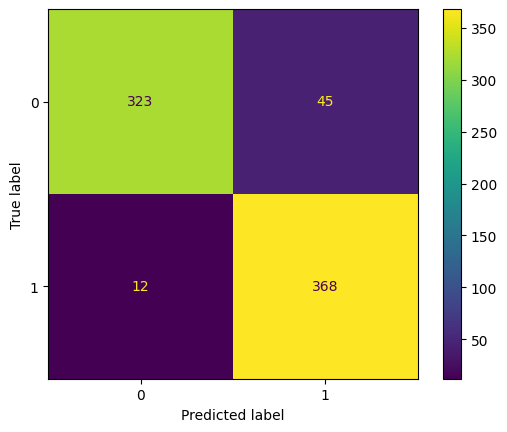

Accuracy is 0.9237967914438503
Precision is 0.8777173913043478
Recall is 0.9641791044776119


In [14]:
# Generate the confusion matrix for the results
plt.clf()
pred_cleaned = pred_df[(pred_df.predicted == "Real") | (pred_df.predicted == "Bogus")]
cm = confusion_matrix(pred_cleaned.actual, pred_cleaned.predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
# Calculate TP, TN, FP, FN
TP = cm[0][0]
TN = cm[1][1]
FP = cm[0][1]
FN = cm[1][0]
# Print the metrics
print(f"Accuracy is {(TN+TP)/(TN+TP+FP+FN)}")
print(f"Precision is {TP/(TP+FP)}")
print(f"Recall is {TP/(TP+FN)}")

In [15]:
# Log the KPI and conclude the experiment
aiplatform.log_metrics(build_experiment_vars(accuracy=(TN+TP)/(TN+TP+FP+FN), precision=TP/(TP+FP), recall=TP/(TP+FN)))
aiplatform.end_run()